## 1.0 Introduction

This is the 2024 rewrite of my notebook on executing the task of translation using Machine Learning by utilizing the Transformer architecture. The objective of this notebook is to implement the architecture from scratch by relying on lower-level TensorFlow functions, classes and utilities as much as possible. 

This first section of the notebook will involve implementing the architecture as mentioned above by using the default methodology described by the [Attention is all You Need paper](https://arxiv.org/abs/1706.03762). As the transformer is being developed in code, there will be markdowns explaining what is being implemented. 

The second section of the notebook involves exploring the dataset prepared for the task of translating between ```French``` and ```English``` sentence pairs. 

The third section of the notebook involves creating a wrapper function for easy inference of the transformer model. Also, we'll explore building the model in Keras Functional API which will abstract away some of the lower-level code and implementations carried out here.

### The Transformer

![The Transformer](https://miro.medium.com/max/700/1*BHzGVskWGS_3jEcYYi6miQ.png)


After the revolution of the research paper from scientists at Google in 2017, [Attention is all you need](https://arxiv.org/abs/1706.03762), the field of Natural Language Processing (and even Computer Vision) exploded with the new architecture proposed. The Transformer architecture rose to prominence because it dealt away with `recurrence` needed in other NLP architectures like RNNs (Recurrent Neural Networks) and LSTMs (Long Short-term Memory Networks). 

RNNs and LSTMs process text sequentially, one word at a time. This creates a bottleneck, as computations for each word depend on the outcome of the previous one. This limits parallelization and makes processing long sequences time-consuming and computationally expensive. The Transformer's core is a mechanism called self-attention. It allows the model to: Consider all words in the input sentence simultaneously. This allows it to analyze how each word relates to all other words, determining which words are more important to pay attention to for a given task. Without this sequential dependence, Transformers can process entire sequences in parallel, dramatically speeding up training and inference on large datasets.

Popular Transformers in use in the current ML landscape include encoder only, decoder only and also encoder-decoder models. Encoder only models like BERT (Bidirectional Encoder Representations from Transformers) and its variants like RoBERTa, DistilBERT etc convert an input sequence of text into a rich numerical representation. This makes it quite useful in tasks like text classification or named-entity recognition where BERT, for example, is used as a base pretrained model to finetune for the task at hand. 

Decoder only models like the family of GPT (Generative Predictive Transformers) will autocomplete the sequence by iteratively predicting the most probable next word. This makes them quite useful in tasks like code completion, sentence generation, summarization and so on. Examples of common Decoder only models are GPT-3, GPT-4 and T5.

Encoder-Decoder models, like the one built in this notebook, maps complex mappings from one sequence of text to another suitable for tasks like summarization and translation. The Encoder takes an input sequence of text (e.g., an article, a sentence in one language).
Processes it word by word, building an internal representation or context vector. The decoder receives the context vector from the encoder and then generate the output sequence (e.g., a summary, a translation) one word or token at a time.



### High Level Explanation of Architecture

![](https://www.tensorflow.org/images/tutorials/transformer/standard_transformer_architecture.png)

Let's offer a high-level explanation of the transformer architecture here block by block:

The Transformer starts by generating initial representations, or embeddings, for each word. Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context. This step is then repeated multiple times in parallel for all words, successively generating new representations.

a. The Transformer consists of two arms - the Encoder and Decoder. The Encoder generates a rich vector representation of the input while the decoder predicts the next token based on the tokens it's being fed. 

b. The input to the Encoder is the word vectors obtained after tokenizing, vectorizing and padding the sequences from the text input. The start_of_sequence and end_of_sequence tokens needs to be added at the start and end of each text input. 

c. A dense vector embeddings of the input text is created. Positional encodings are added to the embeddings and this is fed to several attention heads. Layer normalization and skip connections are involved with this process so as to ensure smooth gradients for backpropagation.

d. The Encoder has N encoder sublayers and the output of one is passed to the next and the output at the top encoder is passed to the decoder.

e. The decoder has almost the exact architecture as the decoder but it computes a second type of attention - ensuring that future predictions only take the current and past tokens into considerations. This is done via masking as implemented in the previous section.

f. The output of the top decoder is passed through a final Dense layer and a softmax layer to output probabilities at each position step. At each step of prediction, the decoder uses only the current and past tokens, and the token with the highest probability at that stage is the output which is further being decoded to have it in text.

## 1.1 Environment Setup

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import keras
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import math
from keras import layers, models


import warnings
warnings.filterwarnings('ignore')

2024-04-09 03:41:31.724876: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 03:41:31.724991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 03:41:31.858500: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
 tf.experimental.numpy.experimental_enable_numpy_behavior()

We need to take advantage of Kaggle's new multi-GPU use with the T4-x2 GPU. Following the steps from [this notebook](https://www.kaggle.com/code/peremartramanonellas/using-multiple-gpu-s-with-tensorflow-on-kaggle) explains how to set it up.

Documentation for [tf.distribute](https://www.tensorflow.org/api_docs/python/tf/distribute)

In [3]:
# Define and get the number os devices. 

#strategy = tf.distribute.MirroredStrategy()
#print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

## 1.2 Implementing the Transformer Architecture

### Embedding and Positional Encoding

As seen in the Transformer architecture diagram above, the first step to implementing the model architecture is the apply embedding on the vector inputs and then add positional encoding to it. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence.


Positional encoding is important because it injects `order` and `position` into the word vectors. Unlike Recurrent Neural Networks (RNNs) and LSTMs that process sequences word by word, Transformers handle entire sequences in parallel and without positional encoding, the model wouldn't be able to differentiate between the meaning of words based solely on their position in the sentence. By adding positional encoding to the word embeddings before feeding them into the Transformer, the model gains the ability to understand the relative and absolute positions of words within the sequence. 

After adding the positional encoding to the word embedding, words will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

There are different implementations for adding positional encoding to embeddings of these vectors (like RoPE) but the method used in the Attention is all You Need paper is defined below.

The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [4]:
class PositionAndTokenEmbedding(layers.Layer):
    def __init__(self, d_model, max_seq_len, vocab_size):
        super(PositionAndTokenEmbedding, self).__init__()
        self.embedding = layers.Embedding(input_dim=vocab_size, output_dim=d_model)

        # Positional Encoding Calculation
        position = tf.expand_dims(tf.range(0, max_seq_len, dtype=tf.float32), axis=1)
        div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * (-math.log(10000.0) / d_model))
        pe = np.zeros((max_seq_len, d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        
        # Convert to tensor and add batch dimension
        self.pe = tf.expand_dims(tf.convert_to_tensor(pe, dtype=tf.float32), axis=0) 

    def call(self, x):
        x = self.embedding(x)
        return x + self.pe[:, :tf.shape(x)[1]] 

### Attention

The primary concept of the Transformers is the self-attention or intra-attention mechanism. The self in self-attention refers to the fact that the attention weights are computed for all hidden states in the same set - for example, all the hidden states of the encoder. As the transformer model processes each word, self-attention allows it to look at other positions in the input sequences for clues that can help it lead to a better encoding for the particular word (or token).

The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

The main idea behind attention is that instead of producing a single hidden state for the input sequence, the encoder outputs a hidden state at each step that the decoder can access. However, using all the states at the same time would create a huge input for the decoder. This is where attention comes in - it lets the decoder assign a different amount of weight or attention to each of the encoder states at every decoding timestep.

Steps:

a. Create three vectors from each of the encoder's input vectors(embeddings of each word). The dimension of the input embeddings is given as d_model in the paper and they used an embedding size of 512. For each attention unit the transformer model learns three weight matrices; the query weights, the key weights, and the value weights. For each token, the input word embedding is multiplied with each of the three weight matrices to produce a query vector Q((vector representation of one word in the sequence), a key vector K (vector representations of all the words in the sequence), and a value vector V(which are the vector representations of all the words in the sequence).

The query Q represents the feature of interest and the matrix K represents the collection of masks. Because it's stored with masks in columns, rather than rows, it needs to be transposed (with the T operator) before multiplying. The vectors q, k, v are smaller in dimension than the embedding vector. The reason for this will be explained soon.

b. Calculate a score: The attention score is calculated by taking the dot product of the query vector and the key vector of the respective word we're scoring. For a sequence of n inputs, we'd have a corresponding n x n matrix of attention scores.

c. Scaling: The attention scores are divided by √dk (dimension of the key vector or depth). This dimension is equal to 64 in the paper, so the matrix of attention scores is scaled by 1/8. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. For example, consider that Q and K have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of dk. So the square root of dk is used for scaling, so you get a consistent variance regardless of the value of dk. If the variance is too low the output may be too flat to optimize effectively. If the variance is too high the softmax may saturate at initialization making it difficult to learn

d. Normalized: The attention scores in the matrix are normalized so that they add up to 1. This is done with the softmax function. The matrix obtained after this step is known as the attention weights.

e. Multiply the value vector V for each word by the attention weights and then sum up to produce the output of the self-attention layer for that position. It is probably helpful to think of the attention weights as where to look and the Value vector as what one wants to actually get. 

In [5]:
def scaled_dot_product_attention(query, key, value, mask = None):
    """
    Returns the attention weights for the query, key, vectors.
    
    Args:
    query - (..., seq_len_q, depth)
    key - (..., seq_len_k, depth)
    value - (..., seq_len_v, depth_v)
    """
    dk = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_dk = tf.math.sqrt(dk)
    
    matmul_qk = tf.matmul(query, key, transpose_b = True)
    scaled_attention_logits = matmul_qk/scaled_dk
    
    if mask is not None:
        mask = tf.cast(mask, tf.float32)
        scaled_attention_logits += (mask * -1e9)
        
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1)
    
    output = tf.matmul(attention_weights, value)
    
    return output, attention_weights
    

In [6]:
# sanity check

q = tf.random.uniform((16, 32, 512))
k = tf.random.uniform((16, 32, 512))
v = tf.random.uniform((16, 32, 512))

output, attn_weight = scaled_dot_product_attention(q, k, v)

output.shape, attn_weight.shape

(TensorShape([16, 32, 512]), TensorShape([16, 32, 32]))

### MultiHead Attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">

Multi-head attention consists of these parts:
*    Linear layers.
*    Scaled dot-product attention.
*    Final linear layer.


The self-attention is refined by carrying it out across several heads. In the paper, they carried out the self-attention step across 8 head. This is known as Multi-Head Attention. Each attention head( (an instance of attention computation) computes its own attention.

So far according to the paper, we have d_model = 512 (dimension of the embeddings), d_k = 64 (dimension of the key and query vectors), and h = 8 (number of attention heads). The paper also used d_v (dimension of the value vector) to be 64 just like the key and query vectors, however this doesn't have to be so.

####  Why is Multi-Head Attention Needed?

Looking at the attention formula given above, we see that the softmax functions which outputs probabilities forces the attention calculation in the range (0, 1) and it helps to emphasize the highest value, while agressively squashing the smallest. The problem with this is that it allows attention to focus on a single element (the one with the highest probability) and leave out the rest which still have a lot of information in them. Sometimes it's useful to keep several of the preceding words in mind when predicting the next, and the softmax just robbed us of that. This is a problem for the model.

The solution to this problem is to have several instances of attention or heads running at once. This lets the the transformer consider several previous words simultaneously when predicting the next. Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information from different representation subspaces at different positions. It brings back the power we had before we pulled the softmax into the picture. 

The intuition behind multi-head attention is that it allows us to attend to different parts of the sequence differently each time. This practically means that:

a. The model can better capture positional information because each head will attend to different segments of the input. The combination of them will give us a more robust representation.

b. Each head will capture different contextual information as well, by correlating words in a unique manner.

However, computing many attention heads require a lot of computation. For the attention step to scale well, the query, key and value vectors are projected into lower-dimensional embedding space. This shrinks the matrices involved and dramatically reduces the computation time.

#### Next step:

However, the next step in the transformer architecture is not receiving matrices from *h* attention heads (8 in the paper). It is expecting a single matrix for each word. So, the multi-head attention matrices would need to be condensed:

a. Concatenate all attention matrices into one giant matrix.

b. Multiply the result of a above by Wo (weight matrix) that was trained jointly with the model.

This is shown below:

![](https://e2eml.school/images/transformers/multihead_attention_equation.png)

In [7]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % num_heads == 0
        
        self.depth = self.d_model//self.num_heads
        
        self.wk = layers.Dense(d_model)
        self.wq = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        
        self.dense = layers.Dense(d_model)
        
    def split_heads(self, x):
        batch_size, seq_len, d_model = x.shape
        
        x = tf.reshape(x, (batch_size, seq_len, self.num_heads, self.depth))
        
        return tf.transpose(x, perm = [0, 2, 1, 3])
    
    def combine_heads(self, x):
        batch_size, _, seq_len, depth = x.shape
        
        return tf.reshape(x, (batch_size, -1, self.d_model))
    
    def __call__(self, query, key, value, mask = None):
        batch_size = tf.shape(query)[0]
        
        # Dense on the query, key, value vectors
        q = self.wq(query)
        k = self.wk(key)
        v = self.wv(value)
        
        # split the heads
        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)
        
        # compute attention weights
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        
        # combine and add Dense Layer  
        output = self.combine_heads(scaled_attention)
        output = self.dense(output)
        
        return output, attention_weights

In [8]:
temp_multihead = MultiHeadAttention(d_model=512, num_heads=8)

y = tf.random.uniform((1, 60, 512))

out, attn = temp_multihead(y, y, y, mask=None)

out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

### Pointwise FeedForward Network

In [9]:
def pointwise_feedforward_network(d_model, dff):
    model = models.Sequential([layers.Dense(dff, activation ='relu'),
                            layers.Dense(d_model)])
    
    return model

In [10]:
# sanity check

sample_ffn = pointwise_feedforward_network(512, 2048)
ffn_output = sample_ffn(tf.random.uniform((64, 50, 512)))

ffn_output.shape

TensorShape([64, 50, 512])

### Encoder Layer

Each encoder layer consists of:

a. Multi-Head Attention layer

b. Feed Forward layer

The encoder layers also include layer normalization and skip connections. This is represented by the Add & Norm section of the transformer architecture diagram above. 

#### Skip Connections
Skip connections occur around the Multi-Head attention blocks and around the element-wise feed forward blocks. Skip connections give a transformer a tiny ability to allow the representations of different levels of processing to interact.

In skip connections, a copy of the input is added to the output of a set of calculations. This is seen in the code block below as the output of the multi-head attention is added to the vector k, q, v again - the inputs to the attention block are added back to its output. Also, the input to the element-wise feed forward network are added to its outputs. 

This serves two purposes:
a. It helps keep the gradient smooth which is a big help for backpropagtion: Attention is a filter, which means that when it is working correctly, it will block most of what tries to pass through it. The result of this is small changes in a lot of the inputs may not produce much change in the output if they happen to fall into the channels that are blocked. This produces dead spots in the gradients where it is flat. Skip connections help to smooth these out.

b. It helps to preserve the original input sequence: Even with lots of attention heads, there's no guarantee a word will attend to its own position. It's possible for the attention filter to forget entirely about the most recent word in favour of watching all of the earlier words that might be relevant. A skip connection takes the original word and manually adds it back into the signal so that there's no way it can be dropped or forgotten.

Thanks to skip connections, successive layers don't provide increasingly sophisticated abstractions as much as they provide redundancy. Whatever opportunities for focusing attention and creating useful features and making accurate predictions were missed in one layer can always be caught by the next.

#### Layer Normalization

The values of the matrix are shifted to have a mean of zero and scaled to have a standard deviation of one.

In [11]:
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate):
        super(EncoderLayer, self).__init__()
        
        self.multihead = MultiHeadAttention(d_model, num_heads)
        self.ffn = pointwise_feedforward_network(d_model, dff)
        self.layernorm1 = layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon = 1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
    def __call__(self, inputs, mask = None):
        attn_outputs, _ = self.multihead(inputs, inputs, inputs, mask)
        attn_outputs = self.dropout1(attn_outputs)
        out1 = self.layernorm1(attn_outputs + inputs)
        
        ffn_outputs = self.ffn(out1)
        ffn_outputs = self.dropout2(ffn_outputs)
        out2 = self.layernorm2(ffn_outputs + out1)
        
        return out2

### Encoder

The Encoder class implemented below consists of the following layers:

a. Embedding and Positional encoding layers

b. Stacks of the encoder sublayers

In [12]:
class Encoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_pe, rate):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.pos_token_embedding = PositionAndTokenEmbedding(d_model, maximum_pe, input_vocab_size)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)
        
    def __call__(self, inputs, mask):
        inputs_embedded = self.pos_token_embedding(inputs)
        inputs_embedded = self.dropout(inputs_embedded)
        
        enc_output = inputs_embedded
        for i in range(self.num_layers):
            enc_output = self.enc_layers[i](enc_output, mask)
            
        return enc_output

In [13]:
# Sanity check

sample_encoder = Encoder(num_layers = 2, d_model = 512, num_heads = 8, dff = 2048, 
                         input_vocab_size = 8500, maximum_pe = 100, rate = 0.1)

temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

enc_output = sample_encoder(temp_input, mask = None)

enc_output.shape

TensorShape([64, 62, 512])

### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention
2.   Multi-head attention. V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

A major difference between each encoder layer and decoder layer is that the decoder has two MultiHeadAttention sublayers as mentioned above.

a. Masked multi-head attention layer: ensures that the tokens we generate at each timestep are only based on the past outputs and current tokens being predicted. To achieve this, we mask the future word embeddings (by setting them to −inf)

b. MultiHeadAttention:This is actually where the decoder processes the encoded representation. The attention matrix generated by the encoder (Value and Key) is passed to another attention layer alongside the result of the previous Masked Multi-head attention block (the Query).

In [14]:
class DecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate):
        super(DecoderLayer, self).__init__()
        
        self.multihead1 = MultiHeadAttention(d_model, num_heads)
        self.multihead2 = MultiHeadAttention(d_model, num_heads)
        self.layernorm1 = layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon = 1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)
        
        self.ffn = pointwise_feedforward_network(d_model, dff)
        
    def __call__(self, inputs, enc_output, src_mask, tgt_mask):
        attn1, attn_weights_block_1 = self.multihead1(inputs, inputs, inputs, tgt_mask)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + inputs)
        
        attn2, attn_weights_block_2 = self.multihead2(out1, enc_output, enc_output, src_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block_1, attn_weights_block_2

### The Decoder

Just like the Encoder, the Decoder also consists of the:

a. Embedding and Positional encoding layers

b. Stacks of decoding layers.


In [15]:
class Decoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_pe, rate):
        super(Decoder, self).__init__()
        
        self.num_layers = num_layers
        self.pos_token_embedding = PositionAndTokenEmbedding(d_model, maximum_pe, target_vocab_size)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)
        
    def __call__(self, inputs, enc_output, src_mask, tgt_mask):
        inputs_embedded = self.pos_token_embedding(inputs)
        inputs_embedded = self.dropout(inputs_embedded)
        
        dec_output = inputs_embedded
        for i in range(self.num_layers):
            dec_output, _, _ = self.dec_layers[i](dec_output, enc_output, src_mask, tgt_mask)
            
        return dec_output

In [16]:
# sanity check

sample_decoder = Decoder(num_layers = 2, d_model = 512, num_heads = 8, dff = 2048, 
                         target_vocab_size = 8500, maximum_pe = 10000, rate = 0.1)

dec_inputs = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

dec_output = sample_decoder(dec_inputs, enc_output, src_mask = None, tgt_mask = None)

dec_output.shape

TensorShape([64, 26, 512])

### The Transformer

![The Transformer](https://miro.medium.com/max/700/1*BHzGVskWGS_3jEcYYi6miQ.png)

Another high-level explanation of the transformer architecture is provided here:

a. The Transformer consists of two arms - the Encoder and Decoder. The Encoder generates a rich vector representation of the input while the decoder predicts the next token based on the tokens it's being fed. The transformer architecture can be used for sequence-sequence tasks like translation.

b. The input to the Encoder is the word vectors obtained after tokenizing and padding the sequences from the text input. The STARTOFSEQUENCE and ENDOFSEQUENCE tokens needs to be added at the start and end of each text input.

c. A dense vector embeddings of the input text is created. Positional encodings are added to the embeddings and this is fed to several attention heads. Layer normalization and skip connections are involved with this process so as to ensure smooth gradients for backpropagation.

d. The Encoder has N encoder sublayers and the output of one is passed to the next and the output at the top encoder is passed to the decoder.

e. The decoder has almost the exact architecture as the decoder but it computes a second type of attention - ensuring that future predictions only take the current and past tokens into considerations. This is done via masking as implemented in the previous section.

f. The output of the top decoder is passed through a final Dense layer and a softmax layer to output probabilities at each position step. At each step of prediction, the decoder uses only the current and past tokens, and the token with the highest probability at that stage is the output which is further being decoded to have it in text.

In [17]:
class Transformer(models.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                 target_vocab_size, maximum_pe, rate):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_pe, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, maximum_pe, rate)
        
        self.final_layer = layers.Dense(target_vocab_size)
        
    def generate_masks(self, src, tgt):
        src_mask = tf.cast(src != 0, tf.bool)  
        src_mask = tf.expand_dims(src_mask, axis=1)  # Add extra dimension for broadcasting
        src_mask = tf.expand_dims(src_mask, axis=2) 
        
        tgt_mask = tf.cast(tgt != 0, tf.bool)
        tgt_mask = tf.expand_dims(tgt_mask, axis=1)
        tgt_mask = tf.expand_dims(tgt_mask, axis=3)  # For compatibility with look-ahead mask
        
        # Look-ahead mask
        seq_length = tf.shape(tgt)[1]
        nopeak_mask = 1 - tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)
        nopeak_mask = tf.cast(nopeak_mask, tf.bool)
        
        # Combine masks
        tgt_mask = tf.logical_and(tgt_mask, nopeak_mask)
        
        return src_mask, tgt_mask
        
    def __call__(self, inputs, targets):
        src_mask, tgt_mask = self.generate_masks(inputs, targets)
        
        enc_output = self.encoder(inputs, src_mask)
        dec_output = self.decoder(targets, enc_output, src_mask, tgt_mask)
        
        final_output = self.final_layer(dec_output)
        
        return final_output

In [18]:
# sanity check


temp_inputs = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_targets = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

temp_transformer = Transformer(num_layers = 2, d_model = 512, num_heads = 8, dff = 2048,
                              input_vocab_size = 8500, target_vocab_size = 8000, 
                               maximum_pe = 100, rate = 0.1)

temp_transformer

<Transformer name=transformer, built=False>

In [19]:
temp_transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_1 (Encoder)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
transformer_output = temp_transformer(temp_inputs, temp_targets)

transformer_output.shape

TensorShape([64, 36, 8000])

## 2.0 The Dataset

In [21]:
dataset = pd.read_csv('../input/english-french-translation/fr-en-translation.csv', nrows=100000, encoding_errors='ignore')
print(len(dataset))
dataset.head(10)

100000


,1,2,Unnamed: 2
0,You thought to this day that there were tyrants?,Vous avez cru jusqu'à ce jour qu'il y avait de...,NaN
1,"How do you feed your family?""","Comment nourrissez-vous votre famille ?""",NaN
2,The first group shows God creating the Heavens...,Le premier ciel est une voûte à laquelle la te...,NaN
3,It is said after this he split to a thousand p...,"Il est dit après cela, qu'il s'est divisé en m...",NaN
4,"They are subservient to him, and created for a...","Ils sont serviles à son égard, et créés pour u...",NaN
5,It is not Allah’s Glory that He should take (t...,Il ne convient pas à Allah de S'attribuer un f...,NaN
6,"Well, we're about to begin our story.","Eh bien, nous sommes sur le point de commencer...",NaN
7,"O' Allah he is from me and I am From Him, he r...","O 'Allah, il est de moi et je suis de Lui, il ...",NaN
8,"Indeed, Allah is but one God.",Allah n'est qu'un Dieu unique.,NaN
9,And for this reason the Scripture says: 'Thus ...,C'est pourquoi le livre de la Genèse dit : « A...,NaN


In [22]:
english_dataset = dataset['1'].values.tolist()
french_dataset = dataset['2'].values.tolist()

for i in range(10, 50, 5):
    print(f"English: {english_dataset[i]}")
    print(f"French: {french_dataset[i]}")
    print("")

English: Those unto whom We gave the Scripture know that it is revealed from your Lord in truth.
French: Ceux auxquels Nous avons donné le Livre savent qu'il est descendu de ton Seigneur avec la vérité.

English: People in Europe and America love my dark skin.
French: Les gens en Europe et en Amérique aime ma peau sombre.

English: We put our hearts and souls into it, and I want them to hear that."
French: Nous y avons mis notre cœur et notre âme, et je veux que les gens l'entendent."

English: She said, "The women are the ones who write the history of the world!
French: Elle s’exprime en ces termes: « Les femmes sont celles qui écrivent l'histoire du monde !

English: But it was too late for my physical development.
French: Mais il était trop tard pour mon développement physique.

English: 1–0 was enough, as long as we could humiliate them.
French: 1-0 était suffisant, tant que nous pourrions les humilier.

English: Declaration of Fundamental Rights and Freedoms adopted by the Parliam

In [23]:
augment_en = pd.read_csv('../input/english-to-french/small_vocab_en.csv', on_bad_lines='skip', header=None, names=['Line 1','Line 2'], nrows=1000)
augment_fr = pd.read_csv('../input/english-to-french/small_vocab_fr.csv', on_bad_lines='skip', header=None, names=['Line A','Line B'], nrows=1000)

augment = pd.concat([augment_en, augment_fr], axis=1)
augment = augment.dropna(how='any')

eng_temp = (augment['Line 1'] + augment['Line 2']).values.tolist()
fr_temp = (augment['Line A'] + augment['Line B']).values.tolist()

for i in range(3):
    print(f"English: {eng_temp[i]}")
    print(f"French: {fr_temp[i]}")
    print("")

English: new jersey is sometimes quiet during autumn  and it is snowy in april .
French: new jersey est parfois calme pendant l' automne  et il est neigeux en avril .

English: the united states is usually chilly during july  and it is usually freezing in november .
French: les états-unis est généralement froid en juillet  et il gèle habituellement en novembre .

English: california is usually quiet during march  and it is usually hot in june .
French: california est généralement calme en mars  et il est généralement chaud en juin .



In [24]:
# let's merge the different data sources
english_dataset.extend(eng_temp)
french_dataset.extend(fr_temp)

len(english_dataset), len(french_dataset)

(100769, 100769)

In [25]:
for i in range(10, 50, 5):
    print(f"English: {english_dataset[i]}")
    print(f"French: {french_dataset[i]}")
    print("")

English: Those unto whom We gave the Scripture know that it is revealed from your Lord in truth.
French: Ceux auxquels Nous avons donné le Livre savent qu'il est descendu de ton Seigneur avec la vérité.

English: People in Europe and America love my dark skin.
French: Les gens en Europe et en Amérique aime ma peau sombre.

English: We put our hearts and souls into it, and I want them to hear that."
French: Nous y avons mis notre cœur et notre âme, et je veux que les gens l'entendent."

English: She said, "The women are the ones who write the history of the world!
French: Elle s’exprime en ces termes: « Les femmes sont celles qui écrivent l'histoire du monde !

English: But it was too late for my physical development.
French: Mais il était trop tard pour mon développement physique.

English: 1–0 was enough, as long as we could humiliate them.
French: 1-0 était suffisant, tant que nous pourrions les humilier.

English: Declaration of Fundamental Rights and Freedoms adopted by the Parliam

In [26]:
del dataset, eng_temp, fr_temp, augment, augment_en, augment_fr

gc.collect()

258

### 2.1 Obtaining statistical information from the dataset

#### Word Cloud

In [27]:
from wordcloud import WordCloud

# let's have a corpus of all the words in the english dataset (limiting to 100,000 examples only)
english_corpus = ' '.join(text for text in english_dataset[:100000])
french_corpus = ' '.join(text for text in french_dataset[:100000])
print(f"There are {len(english_corpus)} nonunique words in the English dataset")
print(f"There are {len(french_corpus)} nonunique words in the French dataset")

There are 9263235 nonunique words in the English dataset
There are 10286958 nonunique words in the French dataset


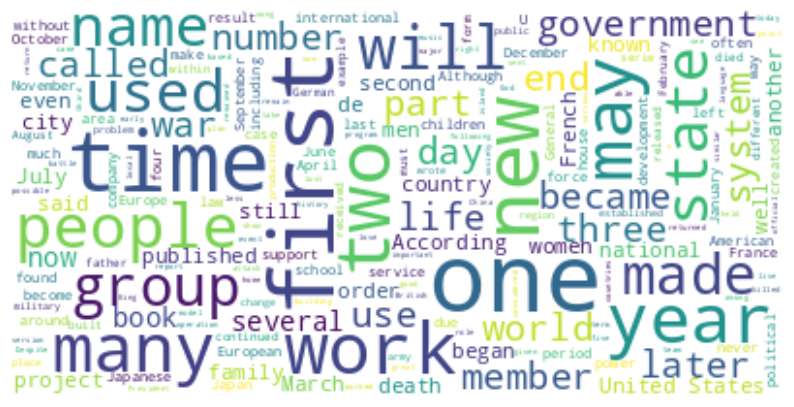

In [28]:
# generate wordcloud for english corpus
wordcloud = WordCloud(max_words=200, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate(english_corpus)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

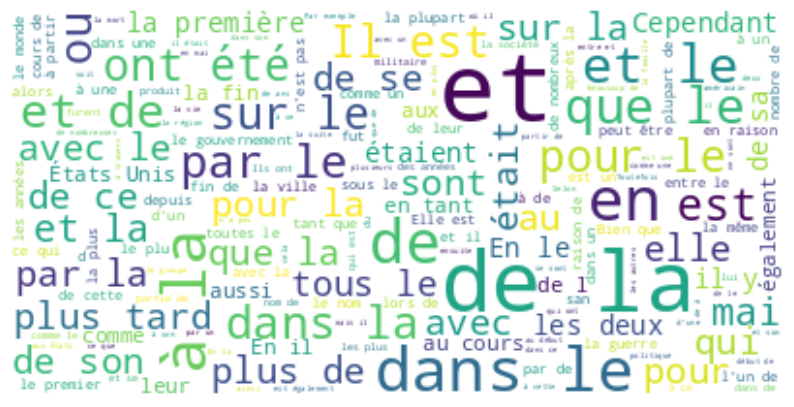

In [29]:
# and for French
wordcloud = WordCloud(max_words=200, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate(french_corpus)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [30]:
del wordcloud

gc.collect()

2146

#### Distribution of Word Count

Text(0.5, 1.0, 'Word Frequency Distribution in French dataset')

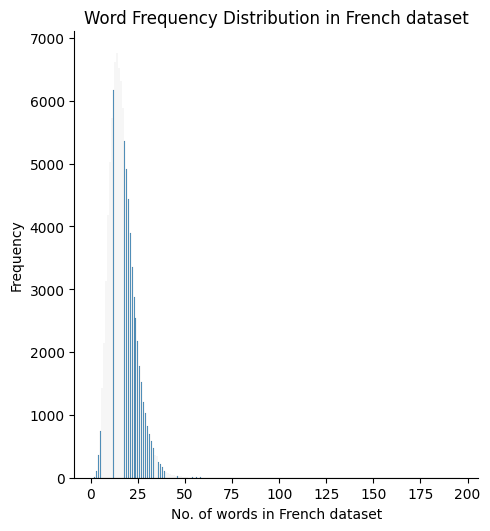

In [31]:
# let's count the number of words in the dataset and see the distribution

fr_text_size = list(map(lambda x: len(x.split()), french_dataset))
sns.displot(fr_text_size)
plt.xlabel('No. of words in French dataset')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution in French dataset')

Text(0.5, 1.0, 'Word Frequency Distribution in English dataset')

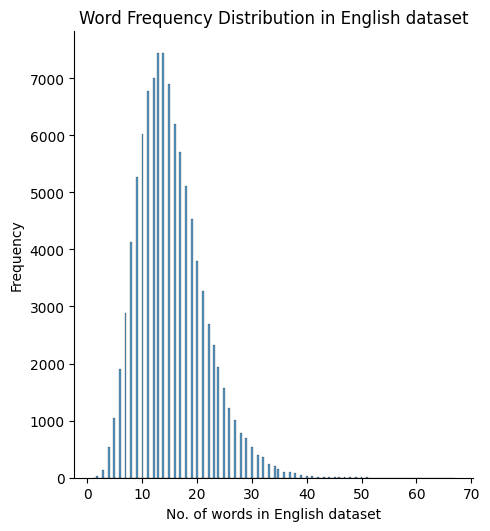

In [32]:
# let's count the number of words in the dataset and see the distribution

eng_text_size = list(map(lambda x: len(x.split()), english_dataset))
sns.displot(eng_text_size)
plt.xlabel('No. of words in English dataset')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution in English dataset')

In [33]:
english_textsize = pd.Series(eng_text_size)
french_textsize = pd.Series(fr_text_size)

eng_mean = english_textsize.mean()
french_mean = french_textsize.mean()

print(f"For English, the average word count per entry is: {eng_mean}")
print(f"For French, the average word count per entry is: {french_mean}")

For English, the average word count per entry is: 15.31116712481021
For French, the average word count per entry is: 16.674205360775634


In [34]:
eng_max = english_textsize.max()
french_max = french_textsize.max()

print(f"For English, the max word count per entry is: {eng_max}")
print(f"For French, the max word count per entry is: {french_max}")

For English, the max word count per entry is: 67
For French, the max word count per entry is: 196


### 2.2  Tokenization

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 80000
tokenizer_en = Tokenizer(num_words=num_words, filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')
tokenizer_fr = Tokenizer(num_words=num_words, filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')

In [36]:
for i in range(len(english_dataset)):
    english_dataset[i] = "sos " + english_dataset[i] + " eos."
    french_dataset[i] = "sos " + french_dataset[i] + " eos."

In [37]:
class TextDataset:
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        
        self.encode(inputs, targets)
        
    def __len__(self):
        return len(self.inputs)
    
    def tokenize(self, sequences, tokenizer):
        tokenizer.fit_on_texts(sequences)
        return tokenizer.texts_to_sequences(sequences)
    
    def pad(self, sequences):
        return pad_sequences(sequences, maxlen = 20, padding='post', truncating = 'post')
    
    def encode(self, en, fr):
        self.inputs = self.tokenize(en, tokenizer_en)
        self.targets = self.tokenize(fr, tokenizer_fr)
        
        self.inputs = self.pad(self.inputs)
        self.targets = self.pad(self.targets)
        
    def __getitem__(self, index):
        en_text = self.inputs[index]
        fr_text = self.targets[index]
        
        return {'english': en_text,
               'french': fr_text}

In [38]:
dataset = TextDataset(english_dataset, french_dataset)

In [39]:
len(tokenizer_en.word_index), len(tokenizer_fr.word_index)

(95455, 122961)

In [40]:
# sanity check

en = dataset[0]['english']
fr = dataset[0]['french']

en = tokenizer_en.sequences_to_texts([en.tolist()])
fr = tokenizer_fr.sequences_to_texts([fr.tolist()])

print(en, fr)

['sos you thought to this day that there were tyrants? eos.'] ["sos vous avez cru jusqu'à ce jour qu'il y avait des tyrans\xa0? eos."]


In [41]:
# save the tokenizers for future user

import pickle

# for english
with open('tokenizer_en.pickle', 'wb') as handle:
    pickle.dump(tokenizer_en, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
# for french
with open('tokenizer_fr.pickle', 'wb') as handle:
    pickle.dump(tokenizer_fr, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 3.0 Training

### Hyperparameters

In [43]:
d_model = 128
dff = 512
num_layers = 4
num_heads = 8
dropout_rate = 0.1

input_vocab_size = len(tokenizer_en.word_index)
target_vocab_size = len(tokenizer_fr.word_index)

maximum_pe = 200

batch_size = 64
epochs = 10

### Loss, Accuracy and Optimizer

In [44]:
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
        
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
        
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [45]:
def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
        
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
        
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [46]:
train_loss = keras.metrics.Mean(name = 'train_loss')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

Using the adamw optimizer described in [the paper](https://arxiv.org/abs/1706.03762)

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [47]:
# learning rate
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model)

In [48]:
#optimizer = keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2 = 0.98, epsilon = 1e-9)

In [49]:
optimizer = keras.optimizers.Adam(learning_rate = 0.001, beta_1=0.9, beta_2 = 0.98, epsilon = 1e-9)

In [50]:
transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, maximum_pe, dropout_rate)

transformer.summary()

Model: "transformer_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_2 (Encoder)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Decoder)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training Loop

In [51]:
train_step_signature = [
    tf.TensorSpec(shape=(batch_size, 20), dtype=tf.int32),
    tf.TensorSpec(shape=(batch_size,20), dtype=tf.int32),
]

@tf.function(input_signature = train_step_signature)    
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
        
        
    with tf.GradientTape() as tape:
        predictions = transformer(inp, tar_inp)
        loss = loss_function(tar_real, predictions)
            
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [52]:
dataset[0]

{'english': array([    2,    94,   659,     6,    20,   150,    12,    54,    21,
        39706,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0], dtype=int32),
 'french': array([    1,   124,  1743,  4920,   166,    32,   192,    55,    58,
           53,    10, 50876,     2,     0,     0,     0,     0,     0,
            0,     0], dtype=int32)}

In [ ]:
import time

for epoch in range(epochs):
    start = time.time()
    
    train_loss.reset_state()
    train_accuracy.reset_state()
    
    start_pt = 0
    
    for i in range(len(dataset)//batch_size):
        data = dataset[start_pt: start_pt + batch_size]
        inp = tf.convert_to_tensor(np.array(data['english']))
        tar = tf.convert_to_tensor(np.array(data['french']))
        
        start_pt += batch_size
        
        train_step(inp, tar)
        
        if i % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
            
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, train_loss.result(), train_accuracy.result()))
    print ('Total time taken for that epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 11.7196 Accuracy 0.0000
Epoch 1 Batch 100 Loss 8.4476 Accuracy 0.0589
Epoch 1 Batch 200 Loss 8.0327 Accuracy 0.0648
Epoch 1 Batch 300 Loss 7.8625 Accuracy 0.0681
Epoch 1 Batch 400 Loss 7.7721 Accuracy 0.0699
Epoch 1 Batch 600 Loss 7.6695 Accuracy 0.0725
Epoch 1 Batch 700 Loss 7.6430 Accuracy 0.0733
Epoch 1 Batch 800 Loss 7.5876 Accuracy 0.0738
Epoch 1 Batch 900 Loss 7.5401 Accuracy 0.0742
Epoch 1 Batch 1000 Loss 7.5040 Accuracy 0.0745
Epoch 1 Batch 1100 Loss 7.4766 Accuracy 0.0747
Epoch 1 Batch 1200 Loss 7.4527 Accuracy 0.0749
Epoch 1 Batch 1300 Loss 7.4322 Accuracy 0.0750
Epoch 1 Batch 1400 Loss 7.4143 Accuracy 0.0751
Epoch 1 Batch 1500 Loss 7.3987 Accuracy 0.0753
Epoch 1 Loss 7.3821 Accuracy 0.0759
Total time taken for that epoch: 658.6361088752747 secs

Epoch 2 Batch 0 Loss 7.9571 Accuracy 0.0617
Epoch 2 Batch 100 Loss 7.1914 Accuracy 0.0762
Epoch 2 Batch 200 Loss 7.1747 Accuracy 0.0775
Epoch 2 Batch 300 Loss 7.1528 Accuracy 0.0783


## 4.0 Evaluation

In [ ]:
maxlen = 25

def evaluate(sentence):
    sentence = 'sos ' + sentence[0] + ' eos'
    sentence = [sentence]
    
    sentence = tokenizer_en.texts_to_sequences(sentence)
    sentence = pad_sequences(sentence, maxlen = 20, padding = 'post', truncating = 'post')
    
    inp = tf.convert_to_tensor(np.array(sentence))
    
    decoder_input = tokenizer_fr.texts_to_sequences(['sos'])
    decoder_input = tf.convert_to_tensor(np.array(decoder_input))
    
    for i in range(maxlen):
        outputs = transformer(inp, decoder_input)
        outputs = outputs[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(outputs, axis=-1), tf.int64)
        
        if predicted_id == tokenizer_fr.texts_to_sequences(['eos']):
            return tf.squeeze(decoder_input, axis=0)
        decoder_input = tf.concat([decoder_input, predicted_id], axis=1)
    return tf.squeeze(decoder_input, axis=0)

In [ ]:
def translate(sentence):
    sentence = [sentence] # our evaluate function requires lists
    print('Input: {}'.format(sentence[0]))
    print("Please wait while we translate: \n")
    result = (evaluate(sentence)).tolist()
    
    predicted_sentence = tokenizer_fr.sequences_to_texts([[i for i in result if i != tokenizer_fr.texts_to_sequences(['sos'])[0][0]
                                                          and i != tokenizer_fr.texts_to_sequences(['eos.'])[0][0]]])  

    
    print('Predicted translation: {}'.format(predicted_sentence[0]))

In [ ]:
sentence = "I love you"
translate(sentence)

In [ ]:
sentence = "C'est un triste jour dans le New Jersey."
translate(sentence)